**Detecting moving objects in Video**

In this notebook, we will demonstrate techniques to detect moving objects in a video from a CCTV camera. The camera will be in a fixed position and does not move. 

We will do the following:

1. Estimate the background with median filering
2. Show how to remove the background from a picture
3. Blurring and thresholding techniques 
4. Detection of countours
5. Implementing the above process on a video

# Import libraries

In [1]:
import numpy as np
import cv2

%matplotlib inline
from matplotlib import pyplot as plt

np.random.seed(42)

Define a routine to fix a color issue to ensure colors are seen correctly in matplotlib

In [2]:
#Routine to fix 
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


## Input

In [18]:
#Take a look at the input video
from IPython.display import Video
#Video("images/overpass.mp4", embed=True)

#Replace with your own video

# Extract background in a video.

We identify a background we will have to use filtering techniques. An easy way to do this is to take a few random frames from the video and finding the median of it. We do this by finding the median of every pixel. This works because most of the time there is no vehicle passing over the road. The median will end filtering all moving objects in the video.

Note that this works if the camera is static and not moving. 

In the section we capture the video in a video stream and get 30 random frames. These frames are saved in the array frames

In [4]:
video_stream = cv2.VideoCapture('images/overpass.mp4')

# Randomly select 30 frames
frameIds = video_stream.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=30)

# Store selected frames in an array
frames = []
for fid in frameIds:
    video_stream.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, frame = video_stream.read()
    frames.append(frame)
    
video_stream.release()


We will now calculate the median and average frames for saved frames. We will use the median as it remove outliers better.

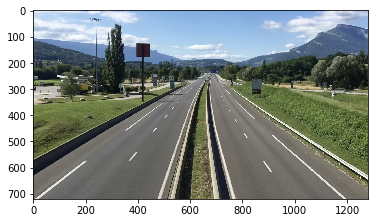

In [5]:
# Calculate the median along the time axis
medianFrame = np.median(frames, axis=0).astype(dtype=np.uint8)
plt.imshow(fixColor(medianFrame))

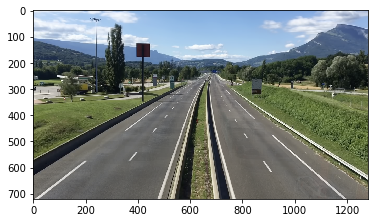

In [6]:
# Calculate the average along the time axis
avgFrame = np.average(frames, axis=0).astype(dtype=np.uint8)
plt.imshow(fixColor(avgFrame))

# Processing a frame 

We will now show how to process a single photo explain all the steps needed. We will take the first frame from our frames array. We can see a few cars in the picture here. 

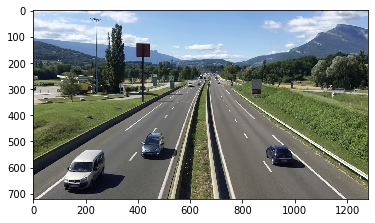

In [7]:
sample_frame=frames[0]
plt.imshow(fixColor(sample_frame))

For identifying moving objects it is better to work with grayscale images. We will convert both the median image and sample image to grayscale

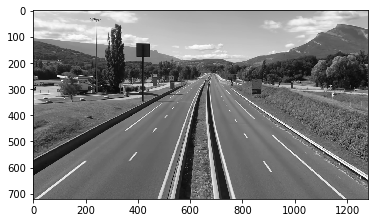

In [8]:
grayMedianFrame = cv2.cvtColor(medianFrame, cv2.COLOR_BGR2GRAY)
plt.imshow(fixColor(grayMedianFrame))

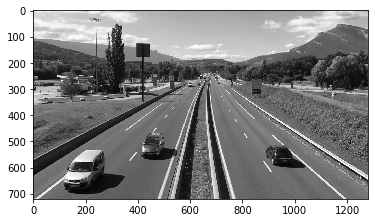

In [9]:
graySample=cv2.cvtColor(sample_frame, cv2.COLOR_BGR2GRAY)
plt.imshow(fixColor(graySample))

## Remove background
Remove the background from our sample. We can now see a ghost image with cars and background removed.

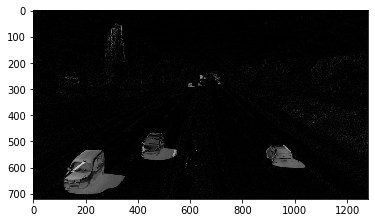

In [10]:
dframe = cv2.absdiff(graySample, grayMedianFrame)
plt.imshow(fixColor(dframe))

## Blurring

We will run Gaussian blurring to reduce noise and enable easier identification of edges

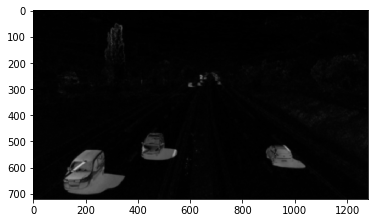

In [11]:
blurred = cv2.GaussianBlur(dframe, (11,11), 0)
plt.imshow(fixColor(blurred))

## Thresholding

We will now run a threshold to clear bring out the objects left here. We will use OTSU thresholding which automatically figure out the correct thresold levels.

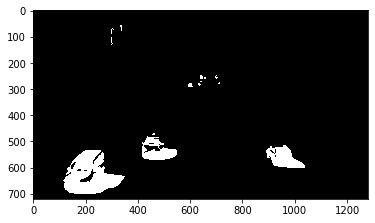

In [12]:
ret, tframe= cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(fixColor(tframe))

## Contour and Bounding Boxes

We will create contours using the thresholded pictures

In [13]:
(cnts, _) = cv2.findContours(tframe.copy(), cv2.RETR_EXTERNAL, 
                             cv2 .CHAIN_APPROX_SIMPLE)

We will now create bounding boxes for the contours identified and show them on our sample images. We will disregard items like moving clouds in the top of our picture

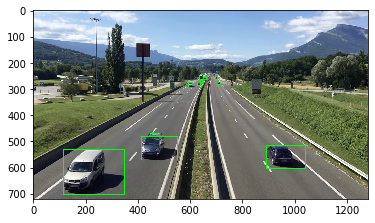

In [14]:
for cnt in cnts:
    x,y,w,h = cv2.boundingRect(cnt)
    if y > 200:  #Disregard item that are the top of the picture
        cv2.rectangle(sample_frame,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(fixColor(sample_frame))

# Putting in together for processing video

We will first declares the output video which will be create. We use in-built CV2 create an MP4 video, with 30 fps and frame size 640*480

In [15]:
writer = cv2.VideoWriter("output.mp4", 
                         cv2.VideoWriter_fourcc(*"MP4V"), 30,(640,480))

In [16]:
#Create a new video stream and get total frame count
video_stream = cv2.VideoCapture('images/overpass.mp4')
total_frames=video_stream.get(cv2.CAP_PROP_FRAME_COUNT)
total_frames

812.0

In [17]:


frameCnt=0
while(frameCnt < total_frames-1):

    frameCnt+=1
    ret, frame = video_stream.read()

    # Convert current frame to grayscale
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Calculate absolute difference of current frame and
    # the median frame
    dframe = cv2.absdiff(gframe, grayMedianFrame)
    # Gaussian
    blurred = cv2.GaussianBlur(dframe, (11, 11), 0)
    #Thresholding to binarise
    ret, tframe= cv2.threshold(blurred,0,255,
                               cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #Identifying contours from the threshold
    (cnts, _) = cv2.findContours(tframe.copy(), 
                                 cv2.RETR_EXTERNAL, cv2 .CHAIN_APPROX_SIMPLE)
    #For each contour draw the bounding bos
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        if y > 200: # Disregard items in the top of the picture
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

    writer.write(cv2.resize(frame, (640,480)))
 
#Release video object
video_stream.release()
writer.release()
